# Nara Backtesting Platform

This package provides a framework for backtesting algorithmic trading strategies. It includes:

- Strategy base class
- Strategy Manager
- Backtest engine
- Visualization tools

### Imports

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from backtest import Backtest, DisplayBacktest, Strategy

### Define your strategies

1st version : Don't use signals

In [3]:
class MovingAverageStrategy(Strategy):
    def __init__(self, name, tickers, short_window, long_window):
        """
        Initialize the MovingAverageStrategy with specified parameters.

        Parameters:
        name (str): The name of the strategy.
        tickers (list): List of ticker symbols.
        short_window (int): The window size for the short moving average.
        long_window (int): The window size for the long moving average.
        """
        super().__init__(name)
        self.tickers = tickers
        self.short_window = short_window
        self.long_window = long_window

    def calculate_signal(self):
        """
        Calculate the signals for each ticker based on moving averages.
        """
        for ticker in self.tickers:
            # Calculate short and long moving averages
            self.data[f'{self.strategy_name}_{ticker}_short_ma'] = self.data[ticker].rolling(window=self.short_window).mean()
            self.data[f'{self.strategy_name}_{ticker}_long_ma'] = self.data[ticker].rolling(window=self.long_window).mean()
            self.data[f'{self.strategy_name}_{ticker}_signal'] = 0.0
            
            # Generate signals where the short MA is greater than the long MA
            valid_index = self.data.index[self.short_window:]  # Valid index for slicing
            self.data.loc[valid_index, f'{self.strategy_name}_{ticker}_signal'] = np.where(
                self.data.loc[valid_index, f'{self.strategy_name}_{ticker}_short_ma'] > self.data.loc[valid_index, f'{self.strategy_name}_{ticker}_long_ma'], 1.0, 0.0
            )

    def calculate_positions(self):
        """
        Calculate positions based on the signals.

        Returns:
        pd.DataFrame: DataFrame containing the positions for each ticker at the last date.
        """
        positions_list = []
        last_date = self.data.index[-1]
        for ticker in self.tickers:
            positions = pd.DataFrame({
                'time': [last_date],
                'book': self.strategy_name,
                'ticker': ticker,
                'units': np.where(self.data.loc[last_date, f'{self.strategy_name}_{ticker}_signal'] == 1.0, 10, -10)
            })
            positions_list.append(positions)
        return pd.concat(positions_list)

2nd version : use signal dataframe

In [24]:
class MovingAverageStrategy(Strategy):
    def __init__(self, name, tickers, short_window, long_window):
        """
        Initialize the MovingAverageStrategy with specified parameters.

        Parameters:
        name (str): The name of the strategy.
        tickers (list): List of ticker symbols.
        short_window (int): The window size for the short moving average.
        long_window (int): The window size for the long moving average.
        """
        super().__init__(name)
        self.tickers = tickers
        self.short_window = short_window
        self.long_window = long_window

    def calculate_signal(self):
        """
        Calculate the signals for each ticker using precomputed moving averages from self.signals.
        """
        for ticker in self.tickers:
            short_ma_column = f'{self.strategy_name}_{ticker}_short_ma'
            long_ma_column = f'{self.strategy_name}_{ticker}_long_ma'
            self.data[f'{self.strategy_name}_{ticker}_signal'] = 0.0
            
            # Generate signals where the short MA is greater than the long MA
            valid_index = self.data.index[self.short_window:]  # Valid index for slicing
            self.data.loc[valid_index, f'{self.strategy_name}_{ticker}_signal'] = np.where(
                self.signal.loc[valid_index, short_ma_column] > self.signal.loc[valid_index, long_ma_column], 1.0, 0.0
            )

    def calculate_positions(self):
        """
        Calculate positions based on the signals.

        Returns:
        pd.DataFrame: DataFrame containing the positions for each ticker.
        """
        positions_list = []
        for ticker in self.tickers:
            positions = pd.DataFrame({
                'time': self.data.index,
                'book': self.strategy_name,
                'ticker': ticker,
                'units': np.where(self.data[f'{self.strategy_name}_{ticker}_signal'] == 1.0, 10, -10)
            })
            positions_list.append(positions)
        return pd.concat(positions_list)

### Fetch your data and format it as followed

[*********************100%%**********************]  2 of 2 completed


<Axes: xlabel='Date'>

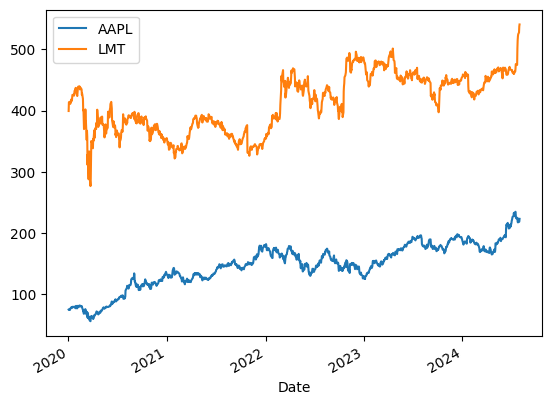

In [21]:
# Define tickers and date range
import pandas as pd
import pandas as pd
tickers = ['AAPL', 'LMT']
start_date = '2020-01-01'
end_date = '2025-01-01'

# Fetch data
data = yf.download(tickers, start=start_date, end=end_date)['Close']

# Format
data.columns = tickers # Ensure the columns are well named
data = data.dropna() # Drop rows with missing values
data.index = pd.to_datetime(data.index) # Convert index to datetime format
data = data.sort_index() # Sort the data by index

# Display
data.plot()

<Axes: xlabel='Date'>

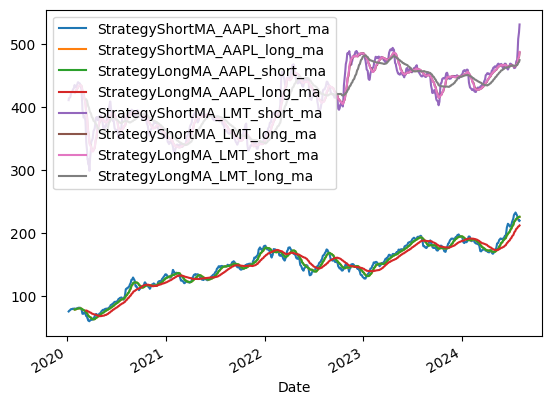

In [22]:
# Calculate moving averages and signals
signals = pd.DataFrame(index=data.index)

for ticker in tickers:
    signals[f'StrategyShortMA_{ticker}_short_ma'] = data[ticker].rolling(window=5).mean()
    signals[f'StrategyShortMA_{ticker}_long_ma'] = data[ticker].rolling(window=21).mean()
    signals[f'StrategyLongMA_{ticker}_short_ma'] = data[ticker].rolling(window=20).mean()
    signals[f'StrategyLongMA_{ticker}_long_ma'] = data[ticker].rolling(window=50).mean()

# Display
signals.plot()

In [25]:
# Initialize and run backtest
strategy1 = MovingAverageStrategy(name="StrategyShortMA", tickers=['AAPL', 'LMT'], short_window=5, long_window=21)
strategy2 = MovingAverageStrategy(name="StrategyLongMA", tickers=['AAPL', 'LMT'], short_window=20, long_window=50)
strategies = [strategy1, strategy2]
weights = {"StrategyShortMA": 0.7, "StrategyLongMA": 0.3}

backtest = Backtest(data, strategies, signals=signals, weights=weights)

  0%|          | 0/1152 [00:00<?, ?it/s]

100%|██████████| 1152/1152 [00:25<00:00, 44.81it/s]


In [26]:
backtest.positions

,time,book,ticker,units
0,2020-01-06,StrategyShortMA,AAPL,-10
1,2020-01-06,StrategyShortMA,LMT,-10
2,2020-01-06,StrategyLongMA,AAPL,-10
3,2020-01-06,StrategyLongMA,LMT,-10
4,2020-01-07,StrategyShortMA,AAPL,-10
...,...,...,...,...
4591,2024-07-29,StrategyLongMA,LMT,10
4592,2024-07-30,StrategyShortMA,AAPL,-10
4593,2024-07-30,StrategyShortMA,LMT,10
4594,2024-07-30,StrategyLongMA,AAPL,10


In [27]:
# Plot results
display = DisplayBacktest(backtest)
display.plot_book("StrategyShortMA")
display.plot_cumulative_pnl_per_book()
display.plot_cumulative_pnl()
display.plot_individual_pnl()
display.plot_pnl_distribution()

# Get yearly and monthly metrics
yearly_metrics = display.get_metrics(book='StrategyShortMA', resample_period='Y')  # Yearly metrics
monthly_metrics = display.get_metrics(book='StrategyShortMA', resample_period='M')  # Monthly metrics

# Export excel
backtest.export_excel("backtest_results.xlsx")

Backtest results exported to backtest_results.xlsx


In [28]:
yearly_metrics

,PnL,Volatility,Max Drawdown,Sharpe Ratio
time,,,,
2020-01-01,874.547272,1632.212062,24.373558,0.535805
2021-01-01,342.901001,790.262496,2.023573,0.433908
2022-01-01,-798.399658,1347.559793,2.876907,-0.592478
2023-01-01,81.899414,824.633270,0.983739,0.099316
2024-01-01,558.299713,839.459869,2.180661,0.665070


In [29]:
monthly_metrics

,PnL,Volatility,Max Drawdown,Sharpe Ratio
time,,,,
2020-01-01,-174.375153,734.396460,24.373558,-0.237440
2020-02-01,609.824829,1314.628565,0.962944,0.463876
2020-03-01,356.874809,4145.849500,1.015023,0.086080
2020-04-01,540.974770,1586.457566,0.496532,0.340995
2020-05-01,-346.650085,1435.286985,5.603221,-0.241520
2020-06-01,238.949585,1271.532402,1.299177,0.187923
2020-07-01,18.750229,1219.468952,0.947564,0.015376
2020-08-01,340.699997,472.153028,0.130822,0.721588
2020-09-01,-391.100464,1318.645270,5.472966,-0.296593
